In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [30]:
%%time
import pandas as pd
face = pd.read_table('vectors_opencvfaces_tagged.tsv', usecols=(0,1,2))
face_vec = np.loadtxt('vectors_opencvfaces_tagged.tsv', dtype=np.dtype('u1'), skiprows=1, usecols=range(3,10003))

CPU times: user 46.7 s, sys: 1.05 s, total: 47.7 s
Wall time: 47.8 s


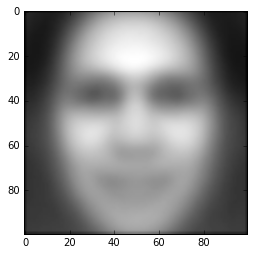

In [32]:
plt.imshow(face_vec.mean(axis=0).reshape(100,100), cmap='gray')

In [183]:
!grep Benno mediatags.tsv

4039	Benno's iPhone met songtext	0
3702	Benno Kruit	71


[(189, 174), (1954, 159), (1942, 121), (3642, 112), (3295, 107), (3631, 88), (109, 80), (1934, 79), (2674, 74), (3296, 71), (3337, 67), (1970, 66), (134, 63), (2628, 63), (1936, 61), (3694, 60), (462, 56), (3630, 54), (2673, 54), (3612, 53)]
41


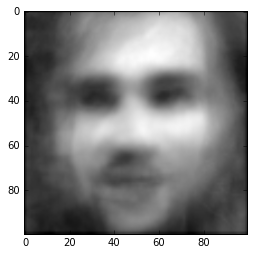

In [184]:
from collections import Counter
c = Counter(face.tag)
print (c.most_common(20))
select = np.array(face.tag==3702)
print (select.sum())
plt.imshow(face_vec[select].mean(axis=0).reshape(100,100), cmap='gray')

# Classification

In [136]:
tags = pd.read_table('mediatags.tsv', index_col=0)
unique_tags, inv = np.unique(face.tag, return_inverse=True)
target_names = list(tags.name[unique_tags])
X,y = face_vec, inv
X.shape, y.shape

((3952, 10000), (3952,))

Extracting the top 150 eigenfaces from 2964 faces
done in 6.518s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.702s
Fitting the classifier to the training set


/root/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


done in 273.295s
Best estimator found by grid search:
SVC(C=5000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 5.403s
                                           precision    recall  f1-score   support

                            Thomas Markus       0.00      0.00      0.00         4
                            Eric Broersma       0.00      0.00      0.00         8
                        Matthijs Melissen       0.00      0.00      0.00         2
                          Lev Beklemishev       0.00      0.00      0.00         3
                          Yvonne Blokland       0.00      0.00      0.00         1
                          Sjoerd Tieleman       0.00      0.00      0.00         2
                                     Bier       0.00      0.00      0.00   

/root/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


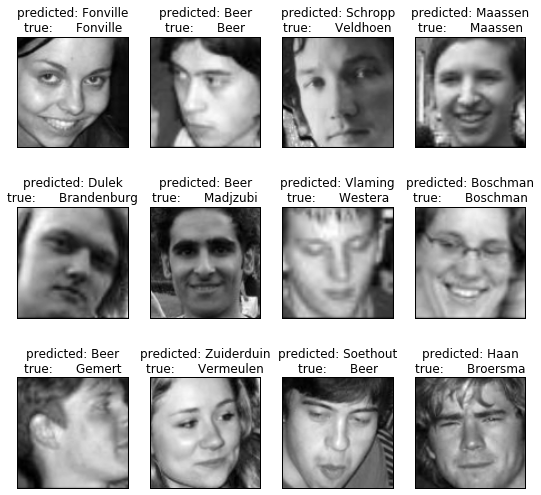

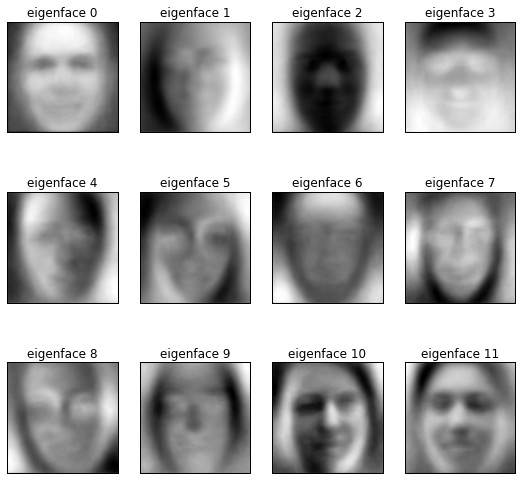

In [185]:
from time import time
import logging

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

h,w = 100,100
n_classes = len(set(y))

###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
# param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
param_grid = {'C': [5e3, 1e4, 5e4],
              'gamma': [0.0005, 0.001, 0.005], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()